# <font color='pickle'>**REFACTOR -using autodiff --Lecture_2_2 LR**

# <font color='pickle'>**Install/import libraries**

In [ ]:
# Install wandb and update it to the latest version
!pip install wandb --upgrade -q

     |████████████████████████████████| 1.8 MB 6.9 MB/s 
     |████████████████████████████████| 158 kB 57.5 MB/s 
     |████████████████████████████████| 181 kB 54.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 58.0 MB/s 
     |████████████████████████████████| 157 kB 63.9 MB/s 
     |████████████████████████████████| 157 kB 61.3 MB/s 
     |████████████████████████████████| 157 kB 58.8 MB/s 
     |████████████████████████████████| 157 kB 19.4 MB/s 
     |████████████████████████████████| 157 kB 59.4 MB/s 
     |████████████████████████████████| 157 kB 44.2 MB/s 
     |████████████████████████████████| 156 kB 55.9 MB/s 


In [ ]:
# Importing PyTorch Library
import torch
import random
import wandb

In [ ]:
# To get deterministic results
torch.manual_seed(456)
random.seed(123)

# <font color='pickle'>**Generating a Dataset**

We will generate a dummy dataset having 1000 observations and 2 features.
The observations are sampled from standard normal distribution.

Let us have our true parameter values to be w = [3, -4.5] and b = 5.2. 

`y = Xw.T + b + noise`

We will further assume that nose will be normally distributed with mean 0 and standard deviation of 0.01. 


In [ ]:
def generate_dataset(w, b, num): 

    """
    Function to generate a dataset. 
    Input parameter : 
    w: weights, 
    b: bias 
    num: number of obervations
    Output: feature and labels of a dataset
    """
    
    # Generate X values from standard normal distribution 
    X = torch.normal(0, 1, (num, len(w.T)))

    # Generate y values: y = Xw + b
    y = torch.mm(X, w.T) + b

    # Adding noise in labels
    
    y += torch.normal(0, 0.01, y.shape)

    # Returning the dataset generated
    return X, y.view((-1, 1))

In [ ]:
# Initializing actual weight and bias values
w_true = torch.Tensor([3, -4.5]).view(1,-1)
b_true = 5.2

# Calling the generate_dataset function to create a dummy dataset
features, labels = generate_dataset(w_true, b_true, 1000)


# <font color='pickle'>**Visualization of the dataset**

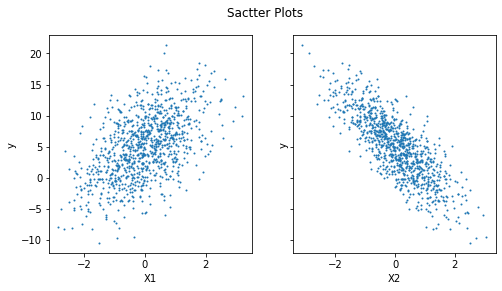

In [ ]:
# Importing matplotlib library for visualizing dataset
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.suptitle('Sactter Plots')

# We will create a scatter plot between feature and labels
ax1.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(),s = 1)
ax1.set(xlabel='X1')
ax1.set(ylabel='y')
ax2.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s = 1)
ax2.set(xlabel='X2')
ax2.set(ylabel='y')

plt.show()

From the above visualization, we can observe a linear relation between features and label values.

# <font color='pickle'>**DataLoaders**

For training our model, we will use mini batches from the dataset and use them to update our model.

To simplify this process, we will define a function which will shuffle the dataset and access it in mini batches.

In [ ]:
def read_data(batch_size, features, labels):
    """
    Function to access data in mini batches. 
    Input parameters: batch size, features, labels. 
    Output: iterator for minibatch data
    """
    
    # Number of examples in the datasets
    num = len(features)

    # Creating a list of indices from 0 to number of examples in the dataset
    indices = list(range(num))

    # The examples are read at random, in no particular order
    random.shuffle(indices)

    # Return the features and labels of the minibatch
    for i in range(0, num, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num)])
        yield features[batch_indices], labels[batch_indices]

Lets create a batch size of 15 and visualize the feature and data values better understanding.

In [ ]:
# Specify value for batch_size
batch_size = 15

# Call the function read_data and visualize the size of minibatch
for X, y in read_data(batch_size, features, labels):
    print(X.shape)
    print(y.shape)
    break

torch.Size([15, 2])
torch.Size([15, 1])


# <font color='pickle'>**Linear Regression Model**

In [ ]:
def linear_reg(X, w, b):
  """
  Function for linear regression y = Xw + b. 
  Input parameter: features, weights, bias. 
  Output: predicted labels
  """
  return torch.mm(X,w.T) + b

# <font color='pickle'>**Loss Function**

In [ ]:
def mse_loss(ypred, y):
  """
  Squared error loss function.
  Input: actual labels and predicted labels
  Output: squared error loss
  """
  error = ypred - y.view(ypred.shape)
  mean_squared_error = error.T.mm(error)/len(y)
  return mean_squared_error

# <font color='pickle'>**Optimization Algorithm**

In [ ]:
# weight update step
def sgd(params, lr):
    with torch.no_grad():
      for param in params:
          param.data -= lr * param.grad
          param.grad.zero_()
        

# <font color='pickle'>**wandb login**

In [ ]:
# Login to W&B
wandb.login()
wandb.init(name = "L_2_LR", project = 'dl22_l2')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hsingh-utd. Use `wandb login --relogin` to force relogin


# <font color='pickle'>**Model Training**

**Model Training** involves five steps: 

- Step 0: Randomly initialize parameters / weights
- Step 1: Compute model's predictions - forward pass
- Step 2: Compute loss
- Step 3: Compute the gradients
- Step 4: Update the parameters
- Step 5: Repeat steps 1 - 4

Model training is repeating this process over and over, for many **epochs**.

## <font color = 'pickle'> **Intialize Model Parameters**

In [ ]:
w = torch.normal(0, 0.01, size=(1, 2), requires_grad=True)

# Create a tensor for bias
b = torch.zeros(1, requires_grad=True)
print(w)

tensor([[-0.0104, -0.0055]], requires_grad=True)


## <font color = 'pickle'> **Training Loop**

In [ ]:
# Set the values for learning rate and number of epochs
lr = 0.005
epochs = 10
params = [w, b]

# Iterate over the whole dataset
for epoch in range(epochs):
    
    # Iterate over mini batch
    for X, y in read_data(batch_size, features, labels):

        # step 1 :forward pass - compute predictions
        ypred = linear_reg(X, w, b)

        # step 2: Calculate minibatch loss
        batch_loss = mse_loss(ypred, y)
        

        # step 3: Compute gradient on loss with respect to weights and bias
        # grad_w = 2 *X.T.mm(ypred-y)/len(y)
        # grad_b = 2 *(ypred-y).sum()/len(y)

        batch_loss.backward()

        # step 4: Update parameters using their gradient using optimization algorithm
        sgd(params, lr)  

    
    # Calculate and print loss for the complete epoch
    train_l = mse_loss(linear_reg(features, w, b), labels)

    # We can observe the epoch vs loss curve in W&B
    wandb.log({"/Loss_2_2": train_l.item()})
        
    print(f'epoch {epoch + 1}, loss {float(train_l.item()):f}')

epoch 1, loss 15.022363
epoch 2, loss 4.405335
epoch 3, loss 1.294533
epoch 4, loss 0.377739
epoch 5, loss 0.111390
epoch 6, loss 0.032954
epoch 7, loss 0.009864
epoch 8, loss 0.003008
epoch 9, loss 0.000970
epoch 10, loss 0.000364


We can observe that with each epoch, our loss is getting reduced hence our linear regression model is able to classify accurately.

Now since we generated the dataset ourselves we know the actual values for weights and bias, so we can check the error in both of them.

In [ ]:
# Printing error in weights and bias
print(f'Error in estimating w: {w_true.view(-1,1) - w}')
print(f'Error in estimating b: {b_true - b}')
print(f'estimated value of w: {w}')
print(f'estimated value of b: {b}')

Error in estimating w: tensor([[ 0.0080,  7.4879],
        [-7.4920, -0.0121]], grad_fn=<SubBackward0>)
Error in estimating b: tensor([0.0088], grad_fn=<RsubBackward1>)
estimated value of w: tensor([[ 2.9920, -4.4879]], requires_grad=True)
estimated value of b: tensor([5.1912], requires_grad=True)


In [ ]:
wandb.finish()

/Loss_2_2,█▃▂▁▁▁▁▁▁▁
/Loss_2_2,0.00036
